In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator

from scipy.optimize import root_scalar

from gpcg import GPCGSolver
from gpcg import make_1d_signal, make_shepp_logan_image, build_1d_first_order_grad, build_2d_first_order_grad

# Toy problem

In [125]:
# Parameters for the problem
n = 100
reg_lambda = 1e2
blur_sigma = 1.5
noise_sigma = 0.2

# Make test signal
dom = np.linspace(0, 1, 100)
x = make_1d_signal( dom ) + np.sin(5*dom)
x_true = x.copy()

In [126]:
# Setup measurement and regularization operators
_matvec = lambda x: gaussian_filter(x, sigma=float(blur_sigma), mode="wrap")
F = LinearOperator((n,n), matvec=_matvec, rmatvec=_matvec)

# Build \lambda R operator
rmat = build_1d_first_order_grad(n, boundary="zero")
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

In [127]:
# Create some artificial data
np.random.seed(0)
y = F.matvec(x) + noise_sigma*np.random.randn(n)

# Get solution via standard cg
scipy_cg_sol, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec(y) , maxiter=1e5)

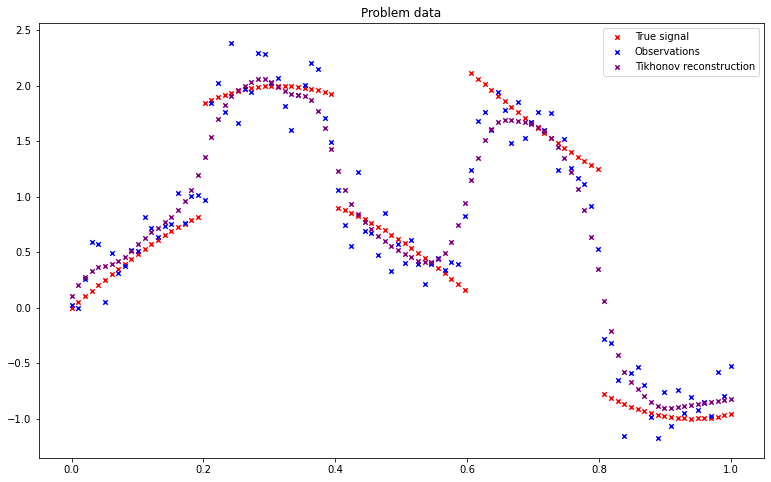

In [128]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_cg_sol, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.legend()
plt.title("Problem data")
plt.show()

In [129]:
A = F
b = y
#print(np.linalg.norm((A @ x) - y))
n = F.shape[1]
x = np.zeros(n)
r_prev = b - (A @ x)
d_prev = A.T @ r_prev
n_iterations = 1
tau = 1.03
rel_errs = []
squared_residuals = []
squared_res = np.linalg.norm((A @ x) - b)**2

squared_residuals.append(squared_res)
for k in range(n_iterations):

    alpha = (np.linalg.norm(A.T @ r_prev)**2)/(np.linalg.norm(A @ d_prev)**2)
    x = x + alpha*d_prev
    r_next = r_prev - alpha*(A @ d_prev)
    beta = (np.linalg.norm(A.T @ r_next)**2/(np.linalg.norm(A.T @ r_prev)**2))
    d_next = (A.T @ r_next) + beta*d_prev

    true_rel_err = np.linalg.norm(x - x_true)/np.linalg.norm(x_true)
    rel_errs.append(true_rel_err)

    squared_res = np.linalg.norm((A @ x) - b)**2
    squared_residuals.append(squared_res)

    #check = np.linalg.norm((A @ x) - b)**2 < tau*A.shape[0]*(noise_sigma**2)
    #if check: print("found one")
    #print(np.linalg.norm((A @ x) - y))

    d_prev = d_next
    r_prev = r_next

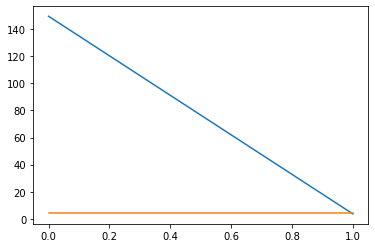

In [130]:
plt.plot(squared_residuals)
plt.plot( ( (noise_sigma**2)*A.shape[0]  )*np.ones_like(squared_residuals) )
plt.show()

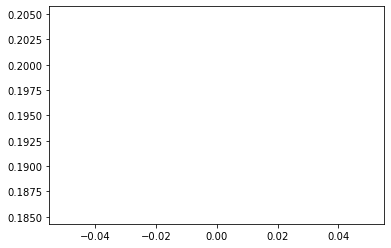

In [131]:
plt.plot(rel_errs)
plt.show()

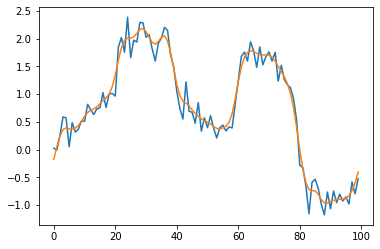

In [132]:
plt.plot(y)
plt.plot(x)
plt.show()

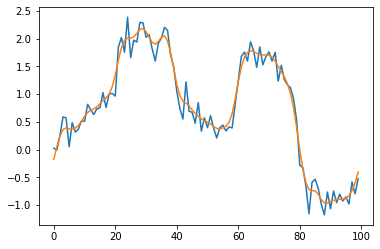

In [133]:
plt.plot(y)
plt.plot(x)
plt.show()

# Function

In [134]:
def cgls_early_stopping_regularization(A, y, noise_sigma, maxits=100, tau=1.03, early_stopping=True):
    """Performs CGLS with early stopping regularization applied to minimizing
                || A x - y ||_2 ,
    stopping at the first iteration such that
        || A x - y ||_2^2 <= tau * m * noise_var.
    """

    #print(np.linalg.norm((A @ x) - y))
    n = F.shape[1]
    m = F.shape[0]
    x = np.zeros(n)
    r_prev = b - (A @ x)
    d_prev = A.T @ r_prev

    # Tracking
    squared_residuals = []
    squared_res = np.linalg.norm((A @ x) - b)**2
    squared_residuals.append(squared_res)
    n_iterations = 0

    for k in range(maxits):

        # CGLS iteration
        alpha = (np.linalg.norm(A.T @ r_prev)**2)/(np.linalg.norm(A @ d_prev)**2)
        x = x + alpha*d_prev
        r_next = r_prev - alpha*(A @ d_prev)
        beta = (np.linalg.norm(A.T @ r_next)**2/(np.linalg.norm(A.T @ r_prev)**2))
        d_next = (A.T @ r_next) + beta*d_prev

        d_prev = d_next
        r_prev = r_next

        # Track this
        n_iterations += 1
        squared_res = np.linalg.norm((A @ x) - b)**2
        squared_residuals.append(squared_res)

        if early_stopping and (squared_res < tau*(m*(noise_sigma**2))):
            break

    data = {
        "x": x,
        "n_iterations": n_iterations,
        "squared_residuals": squared_residuals,
    }

    return data


In [135]:
data = cgls_early_stopping_regularization(F, y, noise_sigma, maxits=10, early_stopping=False )

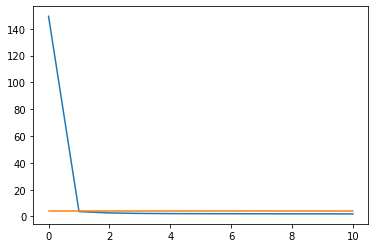

In [136]:
plt.plot(data["squared_residuals"])
plt.plot( ( (noise_sigma**2)*F.shape[0]  )*np.ones_like(data["squared_residuals"]) )
plt.show()

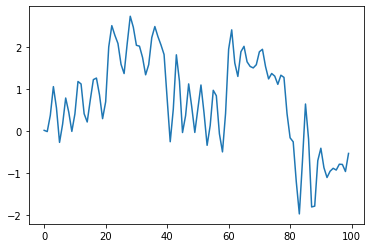

In [137]:
plt.plot(data["x"])
plt.show()

In [138]:
tau = 1.1
data = cgls_early_stopping_regularization(F, y, noise_sigma, maxits=10, early_stopping=True, tau=1.1 )
print(data["n_iterations"])

1


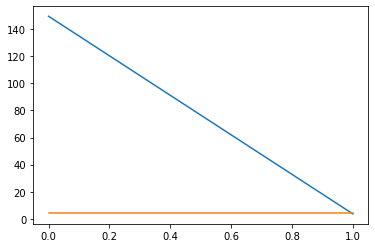

In [139]:
plt.plot(data["squared_residuals"])
plt.plot( tau*( (noise_sigma**2)*F.shape[0]  )*np.ones_like(data["squared_residuals"]) )
plt.show()

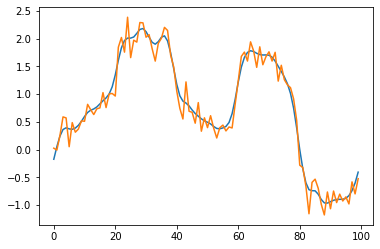

In [141]:
plt.plot(data["x"])
plt.plot(y)
plt.show()

# Comparison

Can we minimize
\begin{align}
\| F x - y \|_2^2 + \| x \|_2^2
\end{align}
by minimizing 
\begin{align}
\| F x - y \|_2
\end{align}
with early stopping?



In [79]:
def cgls_early_stopping2(A, y, noise_sigma, tau=1.03, n_iterations=5):
    """Performs CGLS with early stopping regularization applied to minimizing
                || A x - y ||_2 ,
    stopping at the first iteration such that
        || A x - y ||_2^2 <= tau * m * noise_var.
    """

    A = F
    b = y
    #print(np.linalg.norm((A @ x) - y))
    n = F.shape[1]
    x = np.zeros(n)
    r_prev = b - (A @ x)
    d_prev = A.T @ r_prev

    rel_errs = []
    squared_residuals = []
    squared_res = np.linalg.norm((A @ x) - b)**2

    # original problem?
    original_obj = squared_res + ( np.linalg.norm(x)**2 )
    original_objs = []

    squared_residuals.append(squared_res)
    original_objs.append(original_obj)

    for k in range(n_iterations):

        alpha = (np.linalg.norm(A.T @ r_prev)**2)/(np.linalg.norm(A @ d_prev)**2)
        x = x + alpha*d_prev
        r_next = r_prev - alpha*(A @ d_prev)
        beta = (np.linalg.norm(A.T @ r_next)**2/(np.linalg.norm(A.T @ r_prev)**2))
        d_next = (A.T @ r_next) + beta*d_prev

        true_rel_err = np.linalg.norm(x - x_true)/np.linalg.norm(x_true)
        rel_errs.append(true_rel_err)

        squared_res = np.linalg.norm((A @ x) - b)**2    
        original_obj = squared_res + ( np.linalg.norm(x)**2 )
        original_objs.append(original_obj)
        squared_residuals.append(squared_res)

        #check = np.linalg.norm((A @ x) - b)**2 < tau*A.shape[0]*(noise_sigma**2)
        #if check: print("found one")
        #print(np.linalg.norm((A @ x) - y))

        d_prev = d_next
        r_prev = r_next

    data = {
        "squared_residuals": squared_residuals,
        "original_objs": original_objs,
        "x": x
    }

    return data

In [80]:
data = cgls_early_stopping2(A, y, noise_sigma)

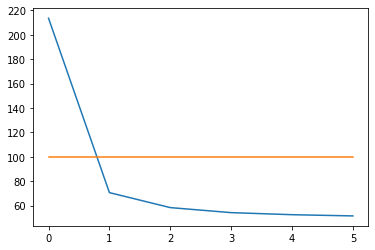

In [85]:
plt.plot(data["squared_residuals"])
plt.plot( ( (noise_sigma**2)*A.shape[0]  )*np.ones_like(data["squared_residuals"]) )
plt.show()

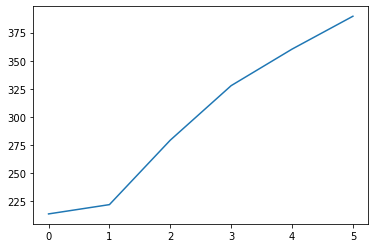

In [82]:
plt.plot(data["original_objs"])
plt.show()

In [86]:
data["original_objs"][1] 

221.81859737396226

In [89]:
1.1*data["original_objs"][0] 

234.90118138893357

# Whitening by noise?

In [236]:
def cgls_for_white_noise_tikhonov(A, b, noise_sigma, maxits=100, tau=1.02, early_stopping=True):
    """Performs CGLS with early stopping regularization applied to minimizing
                || \hat{A} x - \hat{b} ||_2^2 + || x ||_2.
    Here \hat{A}/\hat{b} are re-scalings of A and b by the noise variance. We seek the minimizer by applying
    CGLS towards the minimization of
                || \hat{A} x - \hat{b} ||_2^2
    and using early stopping. We stop at the first iteration such that
                || \hat{A} x - \hat{b} ||_2^2 <= tau * m,
    OR when the original objective function begins to increase.
    """

    # Whiten by noise variance
    A = (1/noise_sigma)*A
    b = (1/noise_sigma)*b

    #print(np.linalg.norm((A @ x) - y))
    n = A.shape[1]
    m = A.shape[0]
    x = np.zeros(n)
    r_prev = b - (A @ x)
    d_prev = A.T @ r_prev

    # Tracking
    squared_residuals = []
    squared_res = np.linalg.norm((A @ x) - b)**2
    squared_residuals.append(squared_res)
    n_iterations = 0

    # original objective?
    prev_original_obj = squared_res + (np.linalg.norm(x)**2)
    original_objs = []
    original_objs.append(prev_original_obj)

    # which stopping criterion satisfied?
    which_broke = "none"

    for k in range(maxits):

        # CGLS iteration
        alpha = (np.linalg.norm(A.T @ r_prev)**2)/(np.linalg.norm(A @ d_prev)**2)
        x = x + alpha*d_prev
        r_next = r_prev - alpha*(A @ d_prev)
        beta = (np.linalg.norm(A.T @ r_next)**2/(np.linalg.norm(A.T @ r_prev)**2))
        d_next = (A.T @ r_next) + beta*d_prev

        d_prev = d_next
        r_prev = r_next

        # Track this
        n_iterations += 1
        squared_res = np.linalg.norm((A @ x) - b)**2
        squared_residuals.append(squared_res)

        next_original_obj = squared_res + (np.linalg.norm(x)**2)
        original_objs.append(next_original_obj)

        if early_stopping and (squared_res < tau*m):
            which_broke = "cgls"
            break

        # print()
        # print(prev_original_obj)
        # print(next_original_obj)

        # print("next > tau*prev?")
        # print(next_original_obj > tau*prev_original_obj)
        # print()

        if early_stopping and (next_original_obj > tau*prev_original_obj):
            which_broke = "original"
            break
        
        # Replace with latest
        prev_original_obj = next_original_obj


    data = {
        "x": x,
        "n_iterations": n_iterations,
        "squared_residuals": np.asarray(squared_residuals),
        "original_objectives": np.asarray(original_objs),
        "which_broke": which_broke,
    }

    return data


In [237]:
data = cgls_for_white_noise_tikhonov(A, y, noise_sigma, maxits=20, early_stopping=True)

In [238]:
data["which_broke"]

'cgls'

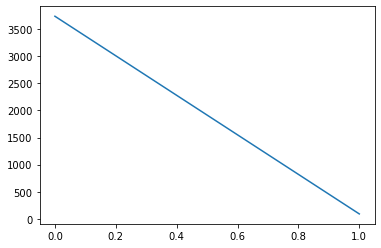

In [239]:
plt.plot(data["squared_residuals"])
plt.show()

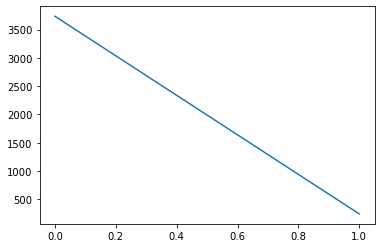

In [240]:
plt.plot(data["original_objectives"])
plt.show()

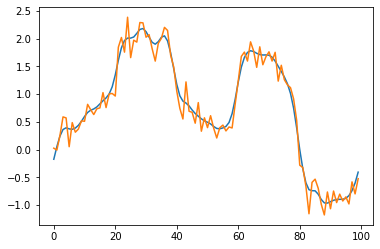

In [241]:
plt.plot(data["x"])
plt.plot(y)
plt.show()

In [309]:
def cgls_for_white_noise_tikhonov_with_lambda(A, b, noise_sigma, lam=1.0, maxits=100, tau=1.02, early_stopping=True):
    """Performs CGLS with early stopping regularization applied to minimizing
                || \hat{A} x - \hat{b} ||_2^2 + lam*|| x ||_2.
    Here \hat{A}/\hat{b} are re-scalings of A and b by the noise variance. First we make the substitution
    z = \sqrt{lam}*x, and convert this to the problem of minimizing
                || C z - \hat{b} ||_2^2 + || z ||_2.
    with C = (1/\sqrt{lam}) \hat{A}. We then seek the minimizer by applying CGLS towards the minimization of
                || C z - \hat{b} ||_2^2
    and using early stopping. We stop at the first iteration such that
                || C z - \hat{b} ||_2^2 <= tau * m,
    OR when the original objective function begins to increase.
    """

    # Whiten by noise variance
    A = (1/noise_sigma)*A
    b = (1/noise_sigma)*b

    # Then, rescale by lam
    C = ( 1.0/np.sqrt(lam) )*A

    #print(np.linalg.norm((A @ x) - y))
    n = C.shape[1]
    m = C.shape[0]
    z = np.zeros(n)
    r_prev = b - (C @ z)
    d_prev = C.T @ r_prev

    # Tracking
    squared_residuals = []
    squared_res = np.linalg.norm((C @ z) - b)**2
    squared_residuals.append(squared_res)
    n_iterations = 0

    # original objective?
    prev_original_obj = squared_res + (np.linalg.norm(z)**2)
    original_objs = []
    original_objs.append(prev_original_obj)

    # which stopping criterion satisfied?
    which_broke = "none"

    for k in range(maxits):

        # CGLS iteration
        alpha = (np.linalg.norm(C.T @ r_prev)**2)/(np.linalg.norm(C @ d_prev)**2)
        z = z + alpha*d_prev
        r_next = r_prev - alpha*(C @ d_prev)
        beta = (np.linalg.norm(C.T @ r_next)**2/(np.linalg.norm(C.T @ r_prev)**2))
        d_next = (C.T @ r_next) + beta*d_prev

        d_prev = d_next
        r_prev = r_next

        # Track this
        n_iterations += 1
        squared_res = np.linalg.norm((C @ z) - b)**2
        squared_residuals.append(squared_res)

        next_original_obj = squared_res + (np.linalg.norm(z)**2)
        original_objs.append(next_original_obj)

        # if early_stopping and (squared_res < tau*m):
        #     which_broke = "cgls"
        #     break

        if early_stopping and (next_original_obj > tau*prev_original_obj):
            which_broke = "original"
            break
        
        # Replace with latest
        prev_original_obj = next_original_obj

    # Recover x
    x = (1.0/np.sqrt(lam))*z

    data = {
        "x": x,
        "n_iterations": n_iterations,
        "squared_residuals": np.asarray(squared_residuals),
        "original_objectives": np.asarray(original_objs),
        "which_broke": which_broke,
    }

    return data


In [310]:
data = cgls_for_white_noise_tikhonov_with_lambda(A, y, noise_sigma, maxits=20, lam=1e4, early_stopping=True)

In [311]:
print(data["n_iterations"])

1


In [312]:
print(data["which_broke"])

original


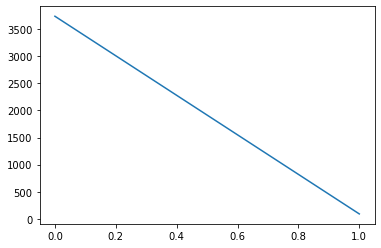

In [313]:
plt.plot(data["squared_residuals"])
plt.show()

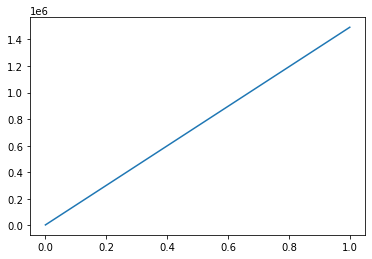

In [314]:
plt.plot(data["original_objectives"])
plt.show()

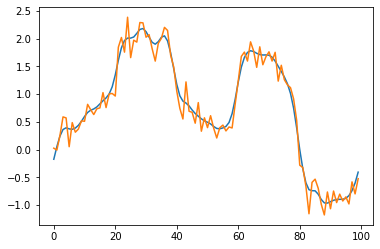

In [315]:
plt.plot(data["x"])
plt.plot(y)
plt.show()

# Example with invertible R?

In [308]:
R = np.eye(n)



(100, 100)